In [2]:
import psutil
print(psutil.virtual_memory())

svmem(total=17179869184, available=1443467264, percent=91.6, used=1964060672, free=16953344, active=1430519808, inactive=1421041664, wired=533540864)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import time
import faiss

/Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or 

In [2]:
filename = "./archive/myntradataset/styles.csv"
df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas

available_ids = os.listdir("./archive/myntradataset/images")
available_ids = [int(x.replace(".jpg","")) for x in available_ids]
df = df[df.id.isin(available_ids)] #some images are not actually available
df=df.dropna(subset='productDisplayName')

df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [3]:
shirts = df.loc[df['articleType'] == 'Jackets']
np.shape(shirts)

(258, 10)

In [4]:
def display_images_and_titles(filepaths, titles):
    # Create a 4x5 grid of subplots
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

    


In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") #Import CLIP Model


In [6]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

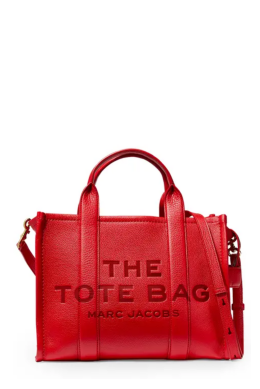

In [7]:
local_pic = "Red_bag.jpg"
image_new = Image.open(local_pic)
text=["blue"]

plt.imshow(image_new)
plt.axis('off')  # Remove the axis labels
plt.show()

In [8]:
inputs = processor(text=text, images=image_new, return_tensors="pt", padding=True)

outputs = model(**inputs)

knn_vectors = torch.load("image_tensor.pt")
knn_labels = df.id.astype(str).tolist()
vectors_np = knn_vectors.numpy()

query_vectors = torch.load("title_tensor.pt")
query_np = query_vectors.numpy()

In [9]:
# Build the index
#dimension = vectors_np.shape[1]  # Dimension of the vectors
dimension = query_np.shape[1] 
index = faiss.IndexFlatL2(dimension)
#index.add(vectors_np)
index.add(query_np)

In [10]:
np_TP = outputs.text_embeds.detach().cpu().numpy()

# Select a query vector
query_vector = np_TP.reshape(1, -1) #This line is different from before

# Query the index
k = 1000  # Number of neighbors to return
D_text, I_text = index.search(query_vector, k)

# `I` now contains the indices of the 10 nearest neighbors to the first vector
# `D` contains the corresponding squared L2 distances

# Get labels of the neighbors
neighbor_labels = [knn_labels[i] for i in I_text[0]]

In [11]:
np_TP = outputs.image_embeds.detach().cpu().numpy()

# Select a query vector
query_vector = np_TP.reshape(1, -1) #This line is different from before

# Query the index
k = 1000  # Number of neighbors to return
D_image, I_image = index.search(query_vector, k)

# `I` now contains the indices of the 10 nearest neighbors to the first vector
# `D` contains the corresponding squared L2 distances

# Get labels of the neighbors
neighbor_labels = [knn_labels[i] for i in I_image[0]]

In [12]:
#Finds the common indexes from the image knn and text knn
common_elements = np.intersect1d(I_image, I_text)

#Makes common elements an array
common_elements_array = common_elements.reshape(1, -1)
#common_elements_array[0]

In [13]:
combo_labels = [knn_labels[i] for i in common_elements_array[0]]

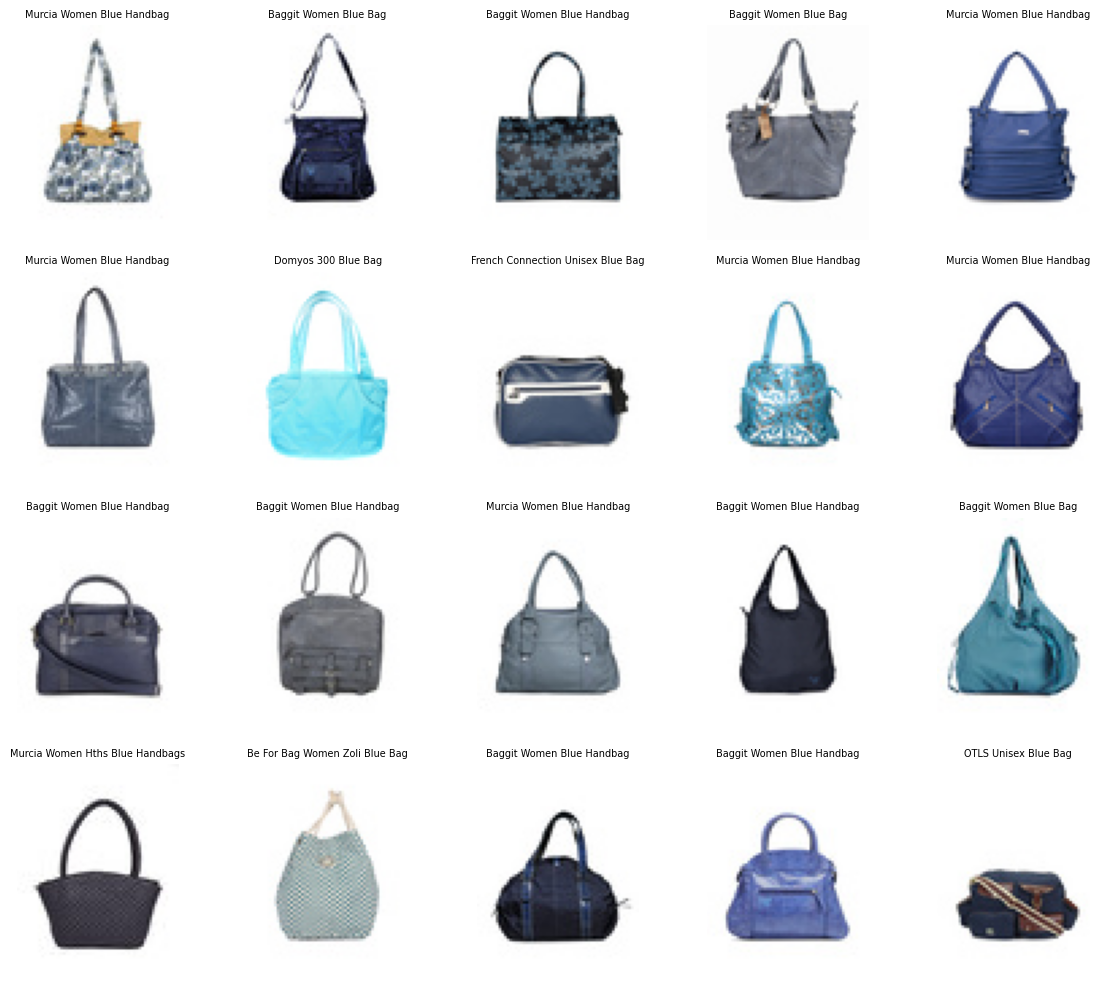

In [14]:
directory = "./archive/myntradataset/images/"
display_images_titles_from_ids(combo_labels, directory)